In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils

In [3]:
# constants
DATASET_NAME = "BA_Grid"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 4

TRAIN_TEST_SPLIT = 0.8
EPOCHS = 3000

visualisation_utils.set_rc_params()

In [4]:
# model definition
class GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes):
        super(GCN, self).__init__()
        
        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)
#         self.conv4 = GCNConv(num_hidden_features, num_hidden_features)
                
        # linear layers
        self.lens = torch.nn.Sequential(te.nn.EntropyLinear(num_hidden_features, 1, n_classes=num_classes))

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)
        
#         x = self.conv4(x, edge_index)
#         x = F.leaky_relu(x)
                
        self.gnn_embedding = x
        
        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        concepts = x
        
        x = self.lens(x)
                
        return concepts, x.squeeze(-1)

In [5]:
def run_grid_search(lr, hidden_units, path):    
    # load data
    G, labels = data_utils.load_syn_data(DATASET_NAME)
    data = data_utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT)

    # model training
    model = GCN(data["x"].shape[1], hidden_units, NUM_CLASSES)
    
    # train 
    train_acc, test_acc, train_loss, test_loss = model_utils.train(model, data, EPOCHS, lr)
        
    visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
    visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
    
    # clean up
    plt.close()

Global seed set to 42



START EXPERIMENT-----------------------------------------

LR: 0.01, HU: 10
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


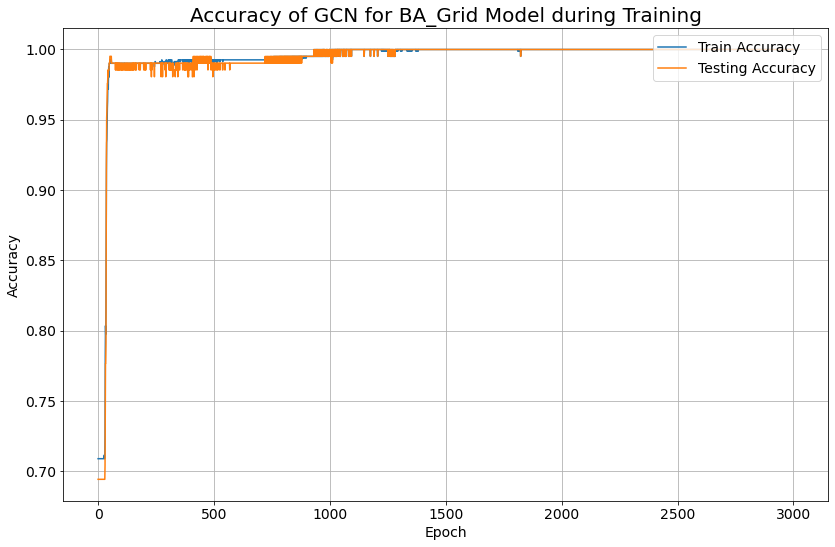

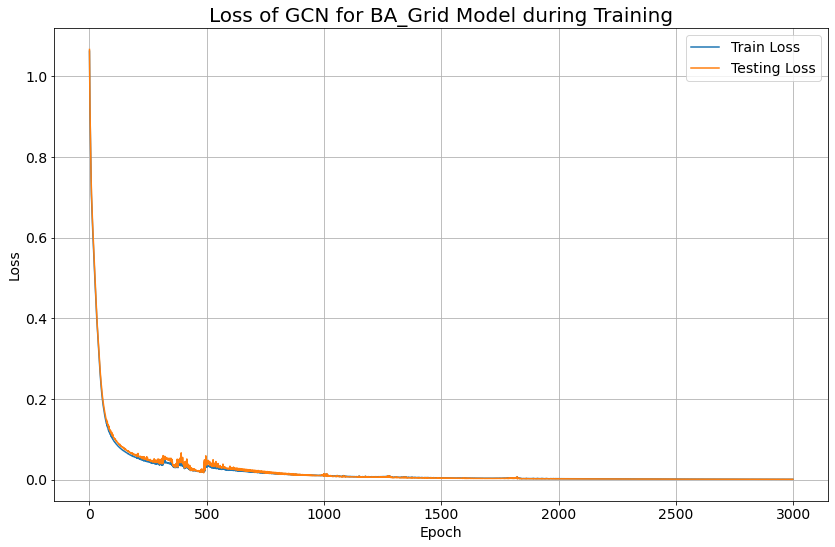

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.01, HU: 20
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


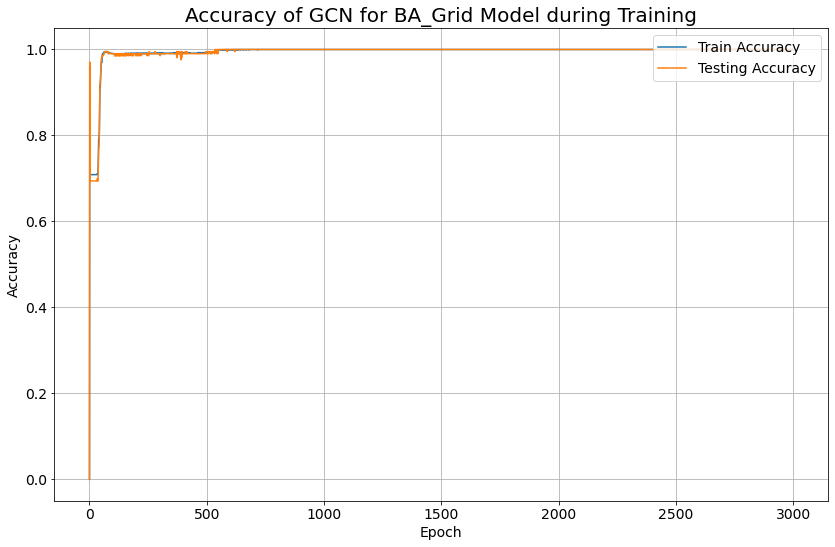

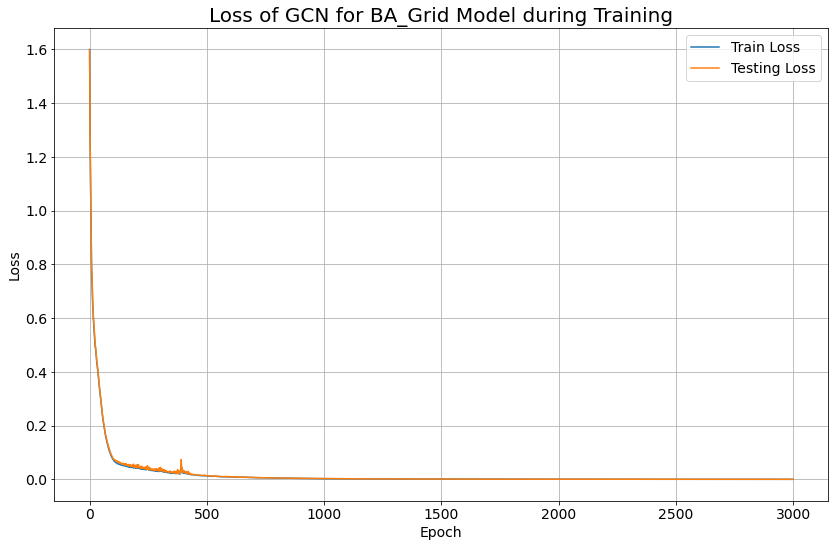

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.01, HU: 30
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


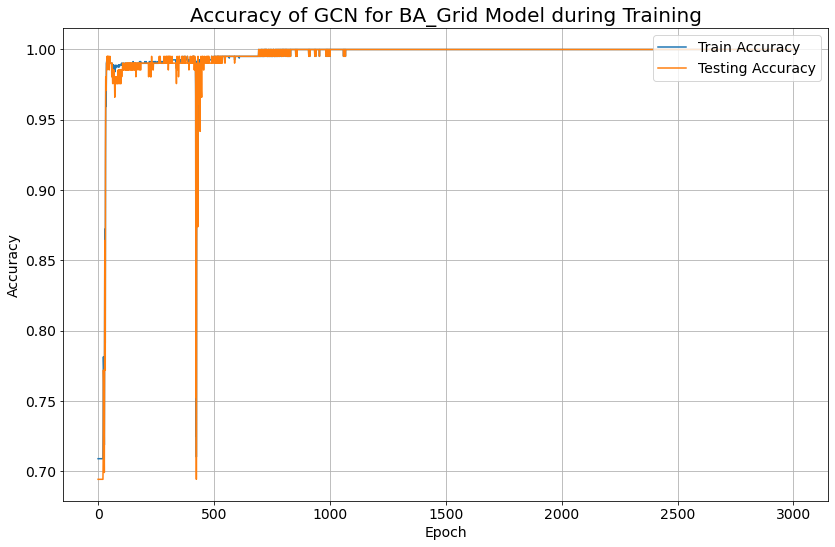

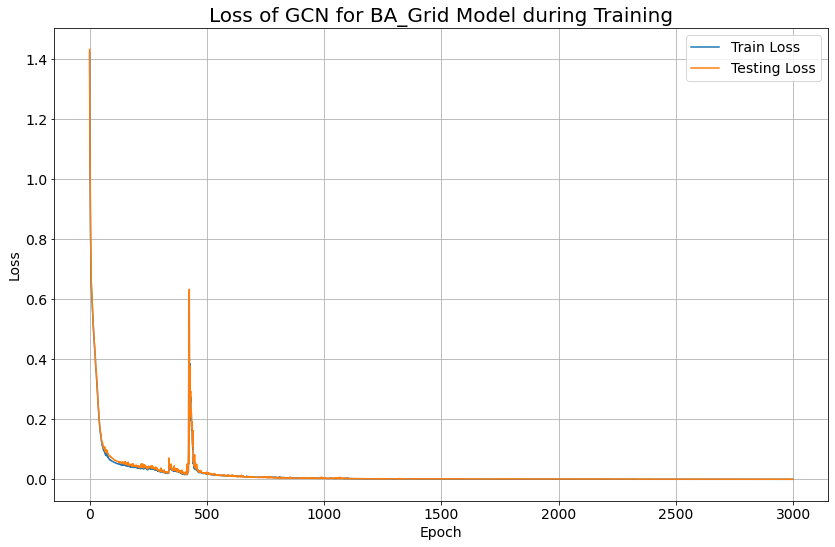

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.001, HU: 10
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


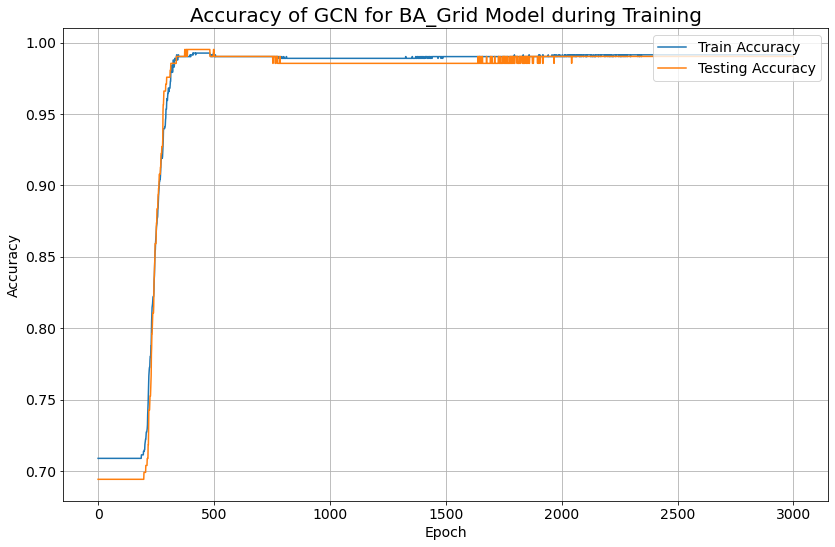

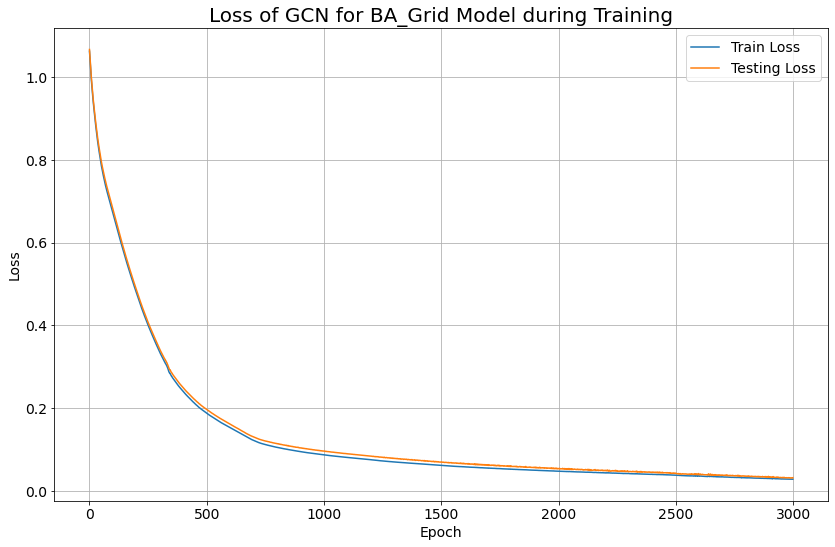

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.001, HU: 20
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


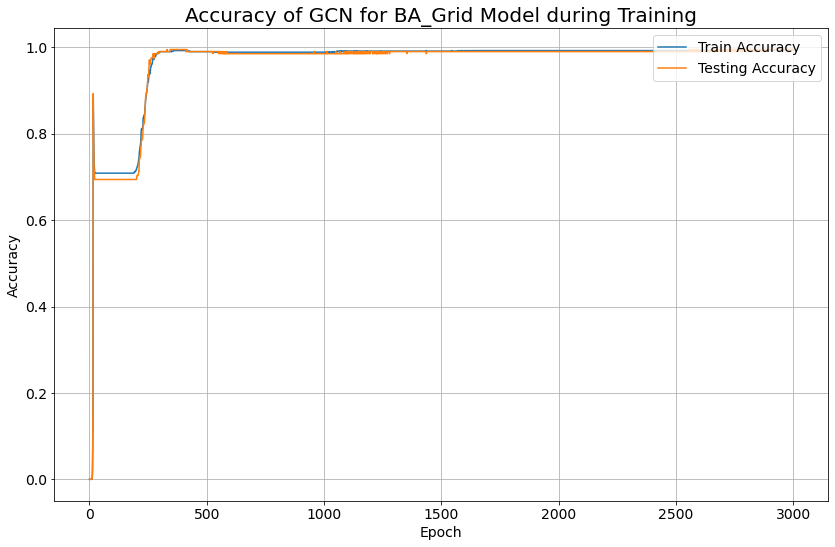

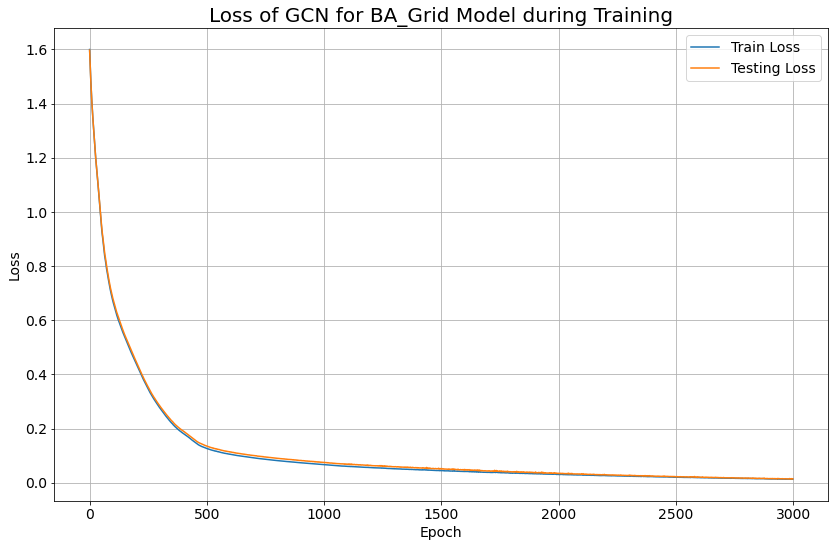

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.001, HU: 30
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


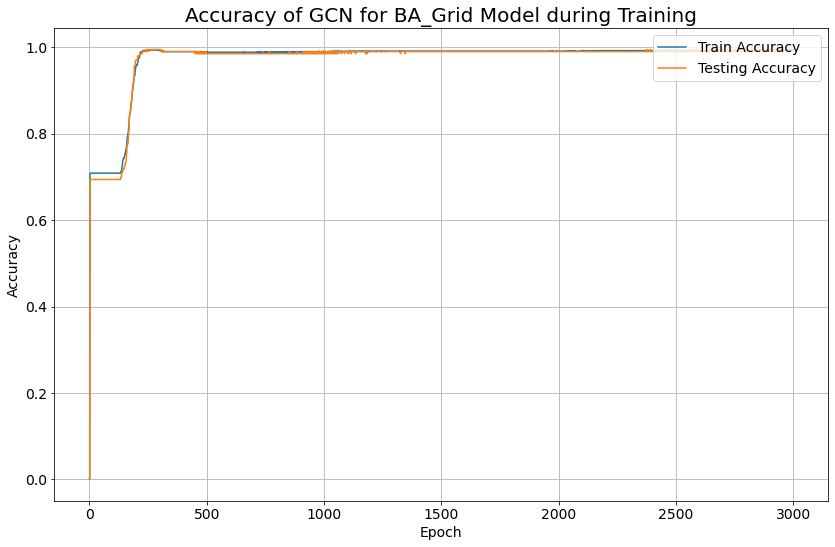

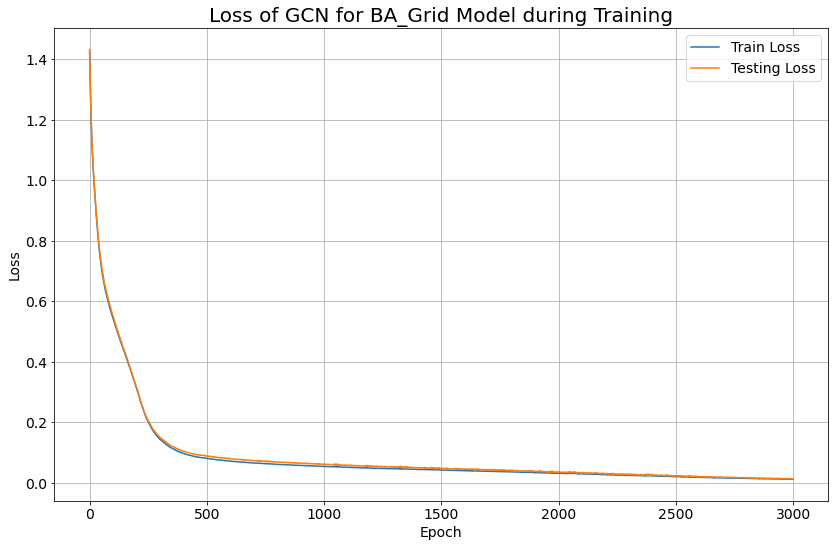

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.0001, HU: 10
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


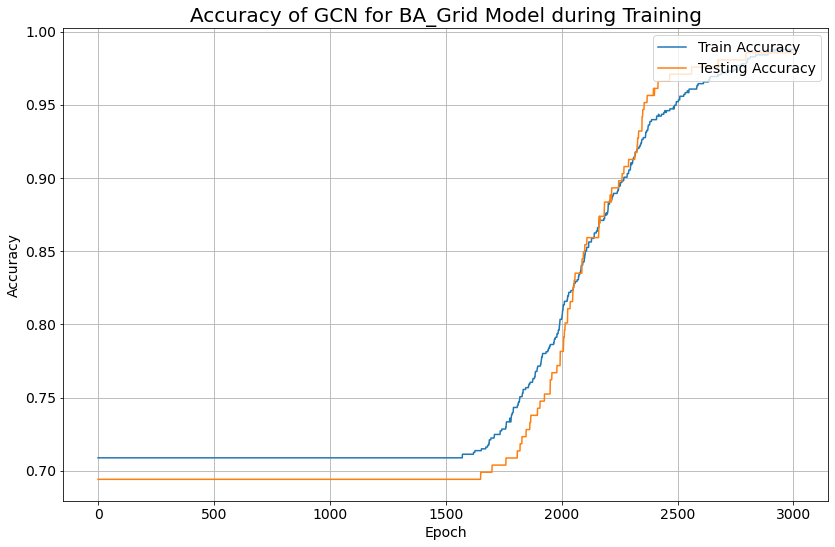

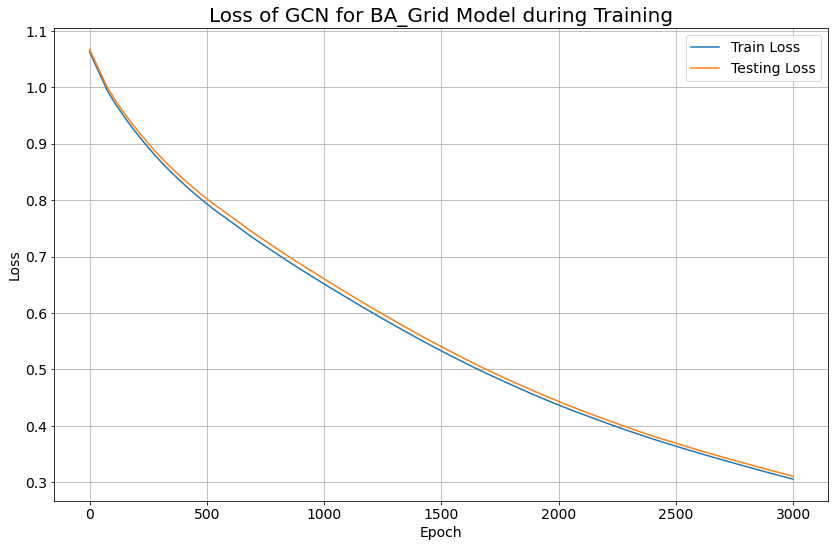

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.0001, HU: 20
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


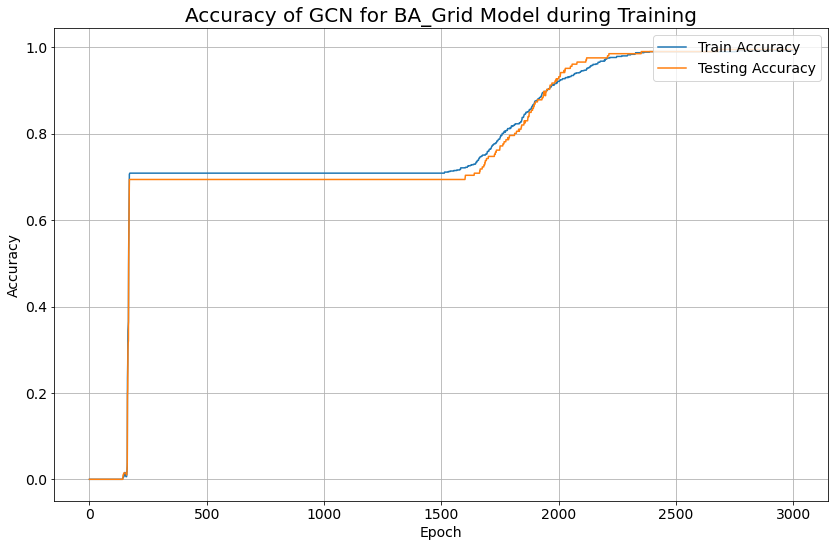

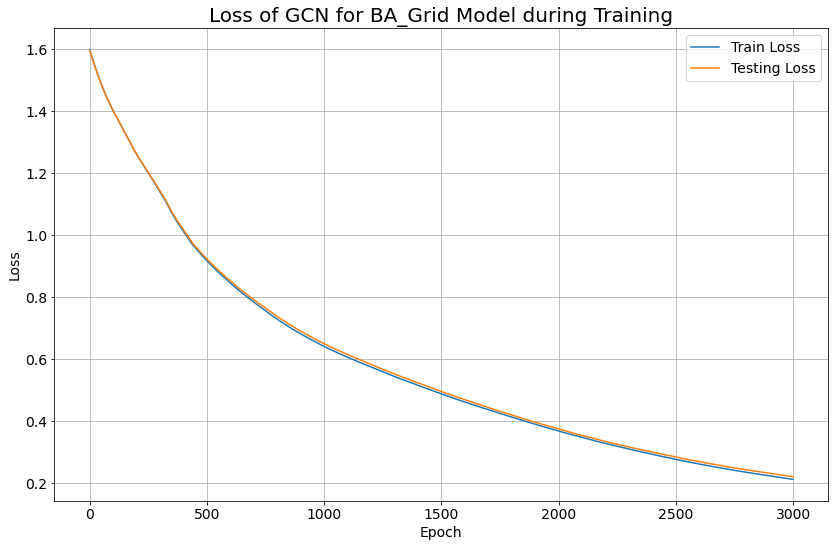

Global seed set to 42



END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

LR: 0.0001, HU: 30
Task: Node Classification
Number of features:  1020
Number of labels:  1020
Number of classes:  1020
Number of edges:  2


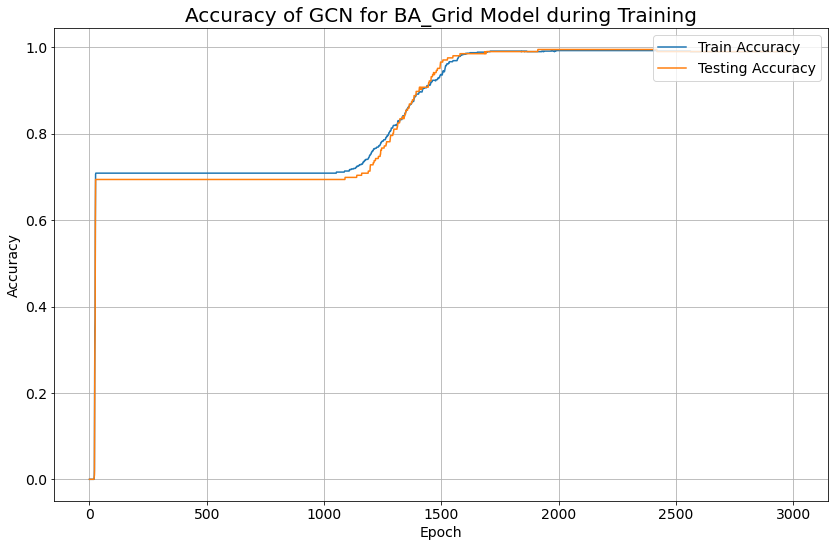

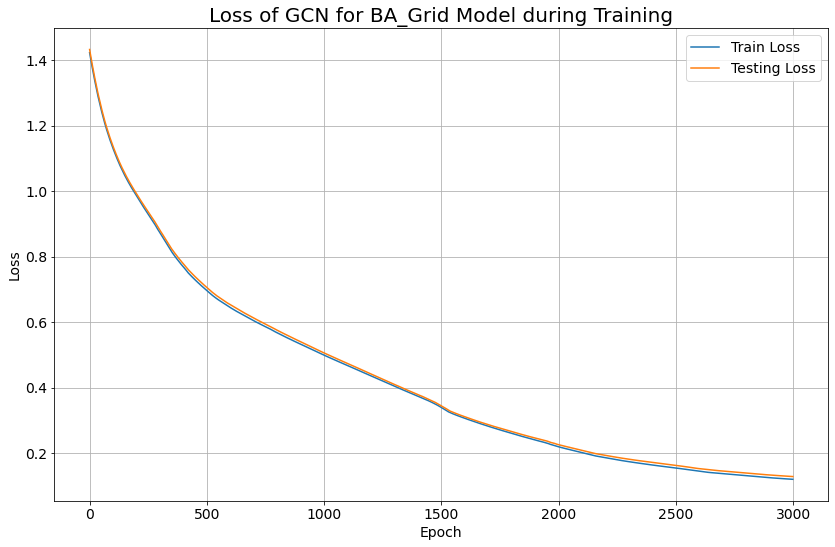


END EXPERIMENT-------------------------------------------



In [6]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
seed = 42
lr_values = [0.01, 0.001, 0.0001]
hidden_units_values = [10, 20, 30]

for lr in lr_values:
    for hidden_units in hidden_units_values:
        print("\nSTART EXPERIMENT-----------------------------------------\n")
        print(f"LR: {lr}, HU: {hidden_units}")
        seed_everything(seed)

        path = os.path.join("..", "output", "grid_search", DATASET_NAME, f"seed_{seed}_lr_{lr}_hu_{hidden_units}")
        data_utils.create_path(path)

        run_grid_search(lr, hidden_units, path)

        print("\nEND EXPERIMENT-------------------------------------------\n")